# Building (Day vs. Night) Histograms

### How to run this notebook:
* Give date and type of vehicle as arguments
* If simplified etapas file does not exist, then run RunDailyEtapasBuilder.runSimplifyEtapas(). If it already exists, then omit it
* If simplified perfiles file does not exist, then run RunDailyEtapasBuilder.runSimplifyPerfiles(). If it already exists, then omit it. TODO: This is not (yet) needed

Run the builder in this order:
1. etapas_df = RunDailyEtapasBuilder.loadSimplifiedEtapas()
2. merged_df = RunDailyEtapasBuilder.includeTorniquetesDate(etapas_df)
3. clean_df = RunDailyEtapasBuilder.cleanDataFrame(merged_df)
4. sorted_df = RunDailyEtapasBuilder.sortDataFrame(clean_df)

In [1]:
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload
import datetime as dt

In [2]:
import RunDailyEtapasBuilder

Enter the date to analyze: 2017-07-19
Enter the vehicle to analyze: BUS
Consider ZP in perfiles file (0/1)?: 0


* Running the builder of the dataframe

In [3]:
#RunDailyEtapasBuilder.runSimplifyEtapas()
etapas_df = RunDailyEtapasBuilder.loadSimplifiedEtapas()
merged_df = RunDailyEtapasBuilder.mergeTurnstileData(etapas_df)
clean_df = RunDailyEtapasBuilder.cleanDataFrame(merged_df)
sorted_df = RunDailyEtapasBuilder.sortDataFrame(clean_df)
sorted_df = sorted_df.reset_index()

Not found in turnstile database: 1637796


* Counting.

In [4]:
print(etapas_df['id'].count())
print(merged_df['id'].count())
print(clean_df['id'].count())
print(sorted_df['id'].count())

2361310
2361310
2326044
2326044


* Adding necessary attributes

In [5]:
sorted_df['mismo_paradero'] = (sorted_df['par_subida']==sorted_df['par_subida'].shift()).fillna(False)
sorted_df['misma_patente'] = (sorted_df['sitio_subida']==sorted_df['sitio_subida'].shift()).fillna(False)
sorted_df['mismo_servicio'] = (sorted_df['servicio_subida']==sorted_df['servicio_subida'].shift()).fillna(False)

sorted_df.loc[(sorted_df.mismo_servicio == True) & (sorted_df.mismo_paradero == True) & (sorted_df.misma_patente == True), 'diferencia_tiempo'] = (sorted_df['t_subida']-sorted_df['t_subida'].shift())

sorted_df['diferencia_tiempo_secs'] = sorted_df['diferencia_tiempo'].dt.total_seconds()
sorted_df['si_torniquete'] = (sorted_df['fecha_instalacion']<=sorted_df['t_subida'])
sorted_df['si_2017_torniquete'] = ((sorted_df['fecha_instalacion']<=sorted_df['t_subida'])&(sorted_df['fecha_instalacion']>=pd.to_datetime('2017-01-01')))

* Filtering by mismo_paradero, misma_patente and by si_torniquete. This is a key part

In [6]:
filtered_df = sorted_df[(sorted_df.mismo_servicio==True) & (sorted_df.mismo_paradero==True) & (sorted_df.misma_patente==True)]
filtered_turnstile_df = filtered_df[filtered_df.si_2017_torniquete==True]
filtered_no_turnstile_df = filtered_df[filtered_df.si_torniquete==False]

* Counting and checking

In [7]:
print(filtered_df['id'].count())
print(filtered_turnstile_df['id'].count())
print(filtered_no_turnstile_df['id'].count())
checking = filtered_turnstile_df['id'].count() + filtered_no_turnstile_df['id'].count()
print(checking)

1427569
176655
998532
1175187


* Getting rid of unecessary dataframes

In [8]:
del etapas_df
del merged_df
del clean_df

* Filtering by period (noc vs. diur)

In [9]:
diur_start_1 = dt.time(0,0,0)
diur_end_1 = dt.time(0,59,0)
noc_start = dt.time(1,0,0)
noc_end = dt.time(5,29,0)
diur_start_2 = dt.time(5,30,0)
diur_end_2 = dt.time(23,59,0)

In [10]:
noc_turnstile_df = filtered_turnstile_df[(noc_start<=filtered_turnstile_df['t_subida'].dt.time) 
                                         & (filtered_turnstile_df['t_subida'].dt.time<=noc_end)]

noc_no_turnstile_df = filtered_no_turnstile_df[(noc_start<=filtered_no_turnstile_df['t_subida'].dt.time)
                                        & (filtered_no_turnstile_df['t_subida'].dt.time<=noc_end)]

diur_turnstile_df = filtered_turnstile_df[((diur_start_1<=filtered_turnstile_df['t_subida'].dt.time)
                                         & (filtered_turnstile_df['t_subida'].dt.time<=diur_end_1))
                                         | ((diur_start_2<=filtered_turnstile_df['t_subida'].dt.time)
                                         & (filtered_turnstile_df['t_subida'].dt.time<=diur_end_2))]

diur_no_turnstile_df = filtered_no_turnstile_df[((diur_start_1<=filtered_no_turnstile_df['t_subida'].dt.time)
                                         & (filtered_no_turnstile_df['t_subida'].dt.time<=diur_end_1))
                                         | ((diur_start_2<=filtered_no_turnstile_df['t_subida'].dt.time)
                                         & (filtered_no_turnstile_df['t_subida'].dt.time<=diur_end_2))]

TODO: Currently, there are rows with extremely high values for the 'diferencia_tiempo' attribute (e.g. >=25 mins). <strong>Be aware of this</strong>. <strike>This should be fixed considering the idExpedicion attribute present in the corresponding 'perfiles' database. The following graphs and descriptive statistics consider only the 95th percentile for the 'diferencia_tiempo_secs' attribute.</strike>

### Filtering by diferencia_tiempo<=97th percentile in the corresponding databases. <font color="red">BE AWARE.</font>

In [11]:
noc_turnstile_97 = noc_turnstile_df.diferencia_tiempo.quantile(0.97)
print ('Percentile 97th for noc_turnstile database is: ' + str(noc_turnstile_97))
noc_no_turnstile_97 = noc_no_turnstile_df.diferencia_tiempo.quantile(0.97)
print ('Percentile 97th for noc_no_turnstile database is: ' + str(noc_no_turnstile_97))
diur_turnstile_97 = diur_turnstile_df.diferencia_tiempo.quantile(0.97)
print ('Percentile 97th for diur_turnstile database is: ' + str(diur_turnstile_97))
diur_no_turnstile_97 = diur_no_turnstile_df.diferencia_tiempo.quantile(0.97)
print ('Percentile 97th for diur_no_turnstile database is: ' + str(diur_no_turnstile_97))

Percentile 97th for noc_turnstile database is: 0 days 00:00:22
Percentile 97th for noc_no_turnstile database is: 0 days 00:00:18
Percentile 97th for diur_turnstile database is: 0 days 00:00:26
Percentile 97th for diur_no_turnstile database is: 0 days 00:00:26


In [12]:
noc_turnstile_97_df = noc_turnstile_df[noc_turnstile_df.diferencia_tiempo<=noc_turnstile_97]
noc_no_turnstile_97_df = noc_no_turnstile_df[noc_no_turnstile_df.diferencia_tiempo<=noc_no_turnstile_97]
diur_turnstile_97_df = diur_turnstile_df[diur_turnstile_df.diferencia_tiempo<=diur_turnstile_97]
diur_no_turnstile_97_df = diur_no_turnstile_df[diur_no_turnstile_df.diferencia_tiempo<=diur_no_turnstile_97]

In [13]:
noc_turnstile_97_df.describe()

,index,id,nviaje,diferencia_tiempo,diferencia_tiempo_secs
count,2.430000e+02,2.430000e+02,243.000000,243,243.000000
mean,1.206796e+06,1.906520e+09,1.024691,0 days 00:00:05.847736,5.847737
std,6.281825e+05,1.330453e+09,0.180127,0 days 00:00:03.495786,3.495786
min,3.235600e+04,2.840050e+07,1.000000,0 days 00:00:01,1.000000
25%,6.517840e+05,4.511938e+08,1.000000,0 days 00:00:04,4.000000
50%,1.197052e+06,2.037343e+09,1.000000,0 days 00:00:05,5.000000
75%,1.708362e+06,3.084727e+09,1.000000,0 days 00:00:06,6.000000
max,2.359592e+06,4.285011e+09,3.000000,0 days 00:00:20,20.000000


In [14]:
noc_no_turnstile_97_df.describe()

,index,id,nviaje,diferencia_tiempo,diferencia_tiempo_secs
count,2.374000e+03,2.374000e+03,2374.000000,2374,2374.000000
mean,1.236666e+06,1.966487e+09,1.024853,0 days 00:00:03.255686,3.255687
std,6.648748e+05,1.393121e+09,0.200646,0 days 00:00:02.617954,2.617955
min,2.580000e+02,1.865935e+07,1.000000,0 days 00:00:00,0.000000
25%,6.616920e+05,4.700391e+08,1.000000,0 days 00:00:02,2.000000
50%,1.235846e+06,2.164363e+09,1.000000,0 days 00:00:03,3.000000
75%,1.828394e+06,3.270444e+09,1.000000,0 days 00:00:04,4.000000
max,2.361205e+06,4.287657e+09,5.000000,0 days 00:00:18,18.000000


In [15]:
diur_turnstile_97_df.describe()

,index,id,nviaje,diferencia_tiempo,diferencia_tiempo_secs
count,1.711680e+05,1.711680e+05,171168.000000,171168,171168.000000
mean,1.164604e+06,1.840977e+09,1.602531,0 days 00:00:05.826346,5.826346
std,6.882338e+05,1.412327e+09,0.851087,0 days 00:00:03.941820,3.941821
min,0.000000e+00,1.091258e+06,1.000000,0 days 00:00:00,0.000000
25%,5.656642e+05,4.242935e+08,1.000000,0 days 00:00:04,4.000000
50%,1.165113e+06,1.936154e+09,1.000000,0 days 00:00:05,5.000000
75%,1.759280e+06,3.169601e+09,2.000000,0 days 00:00:07,7.000000
max,2.361291e+06,4.293088e+09,13.000000,0 days 00:00:26,26.000000


In [16]:
diur_no_turnstile_97_df.describe()

,index,id,nviaje,diferencia_tiempo,diferencia_tiempo_secs
count,9.672810e+05,9.672810e+05,967281.000000,967281,967281.000000
mean,1.184909e+06,1.875986e+09,1.650676,0 days 00:00:03.672535,3.672536
std,6.793143e+05,1.403224e+09,0.874466,0 days 00:00:03.722721,3.722721
min,1.000000e+00,1.091258e+06,1.000000,0 days 00:00:00,0.000000
25%,6.011810e+05,4.270510e+08,1.000000,0 days 00:00:02,2.000000
50%,1.185033e+06,2.035995e+09,1.000000,0 days 00:00:03,3.000000
75%,1.771280e+06,3.170936e+09,2.000000,0 days 00:00:04,4.000000
max,2.361308e+06,4.293295e+09,22.000000,0 days 00:00:26,26.000000


* Plotting

In [17]:
noc_turnstile_values = noc_turnstile_97_df.diferencia_tiempo_secs.values
noc_no_turnstile_values = noc_no_turnstile_97_df.diferencia_tiempo_secs.values
diur_turnstile_values = diur_turnstile_97_df.diferencia_tiempo_secs.values
diur_no_turnstile_values = diur_no_turnstile_97_df.diferencia_tiempo_secs.values

In [18]:
colors = [(85,98,112),(78,205,196),(199,244,100),(255,107,107),(196,77,88)]
for i in range(len(colors)):
    r, g, b = colors[i]  
    colors[i] = (r / 255., g / 255., b / 255.)

* NIGHT: turns vs. without turns

In [19]:
noc_max_97 = max(noc_turnstile_97,noc_no_turnstile_97).total_seconds()
bins = range(0,int(noc_max_97),1)

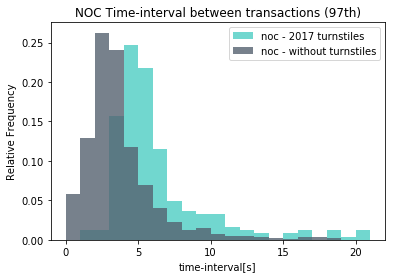

In [20]:
hist_fig, ax = plt.subplots()

plot1 = ax.hist(noc_turnstile_values,normed=True,bins=bins,color=colors[1], alpha=0.8, label='noc - 2017 turnstiles')
plot2 = ax.hist(noc_no_turnstile_values,normed=True,bins=bins,color=colors[0], alpha = 0.8, label='noc - without turnstiles')


ax.set_title('NOC Time-interval between transactions (97th)')
ax.set_xlabel('time-interval[s]')
ax.set_ylabel('Relative Frequency')
ax.legend()
#plt.savefig('C:/Users/Tesista/Desktop/Evasion/03_report/02_Figs/4_NOC-2017-07-19.pdf')

* DAY: turns vs. without turns

In [21]:
diur_max_97 = max(diur_turnstile_97,diur_no_turnstile_97).total_seconds()
bins = range(0,int(diur_max_97),1)

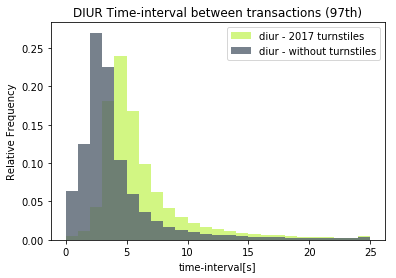

In [22]:
hist_fig, ax = plt.subplots()

plot1 = ax.hist(diur_turnstile_values,normed=True,bins=bins,color=colors[2], alpha=0.8, label='diur - 2017 turnstiles')
plot2 = ax.hist(diur_no_turnstile_values,normed=True,bins=bins,color=colors[0], alpha = 0.8, label='diur - without turnstiles')


ax.set_title('DIUR Time-interval between transactions (97th)')
ax.set_xlabel('time-interval[s]')
ax.set_ylabel('Relative Frequency')
ax.legend()
#plt.savefig('C:/Users/Tesista/Desktop/Evasion/03_report/02_Figs/4_DIUR-2017-07-19.pdf')

* TURNS: day vs. night

In [23]:
turns_max_97 = max(noc_turnstile_97,diur_turnstile_97).total_seconds()
bins = range(0,int(turns_max_97),1)

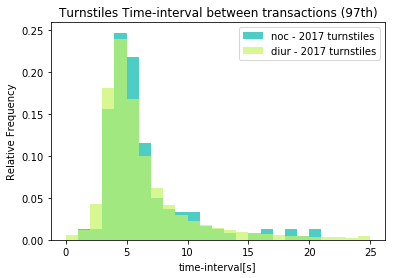

In [24]:
hist_fig, ax = plt.subplots()

plot2 = ax.hist(noc_turnstile_values,normed=True,bins=bins,color=colors[1], alpha = 1, label='noc - 2017 turnstiles')
plot1 = ax.hist(diur_turnstile_values,normed=True,bins=bins,color=colors[2], alpha=0.7, label='diur - 2017 turnstiles')



ax.set_title('Turnstiles Time-interval between transactions (97th)')
ax.set_xlabel('time-interval[s]')
ax.set_ylabel('Relative Frequency')
ax.legend()
#plt.savefig('C:/Users/Tesista/Desktop/Evasion/03_report/02_Figs/4_turnstiles-2017-07-19.pdf')

* NO-TURNS: day vs. night

In [25]:
no_turns_max_97 = max(noc_no_turnstile_97,diur_no_turnstile_97).total_seconds()
bins = range(0,int(no_turns_max_97),1)

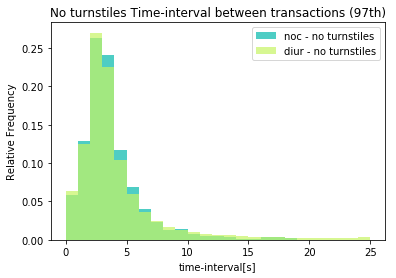

In [26]:
hist_fig, ax = plt.subplots()

plot2 = ax.hist(noc_no_turnstile_values,normed=True,bins=bins,color=colors[1], alpha = 1, label='noc - no turnstiles')
plot1 = ax.hist(diur_no_turnstile_values,normed=True,bins=bins,color=colors[2], alpha=0.7, label='diur - no turnstiles')



ax.set_title('No turnstiles Time-interval between transactions (97th)')
ax.set_xlabel('time-interval[s]')
ax.set_ylabel('Relative Frequency')
ax.legend()
#plt.savefig('C:/Users/Tesista/Desktop/Evasion/03_report/02_Figs/4_no-turnstiles-2017-07-19.pdf')

In [27]:
import scipy as sp
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0*np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * sp.stats.t.ppf((1+confidence)/2., n-1)
    return h, m-h, m, m+h

In [28]:
mean_confidence_interval(noc_turnstile_97_df['diferencia_tiempo_secs'])

(0.4417404879530003,
 5.4059961375614032,
 5.8477366255144032,
 6.2894771134674032)

In [29]:
mean_confidence_interval(noc_no_turnstile_97_df['diferencia_tiempo_secs'])

(0.10536379942324557,
 3.1503228054630226,
 3.255686604886268,
 3.3610504043095135)

In [30]:
mean_confidence_interval(diur_turnstile_97_df['diferencia_tiempo_secs'])

(0.018673973386743689,
 5.807672072603161,
 5.8263460459899044,
 5.8450200193766477)

In [31]:
mean_confidence_interval(diur_no_turnstile_97_df['diferencia_tiempo_secs'])

(0.0074187860313748803,
 3.6651169093870193,
 3.6725356954183943,
 3.6799544814497693)

### Closed